# DTSA - 5509 Final Project - Introduction to Machine Learning: Supervised Learning.

## Using Predictive Analysis To Predict Diagnosis of Breast Cancer

## Project Objective

The primary objective of this project is to develop a classification model that accurately predicts whether a breast tumor is benign or malignant using diagnostic features derived from medical imaging. The model will be trained and evaluated on the Breast Cancer Wisconsin Diagnostic dataset, with the goal of assisting in early cancer detection and supporting medical decision-making.

## Identify the Problem

Breast cancer is the most prevalent type of cancer among women, representing nearly one-third of all cancer diagnoses in the United States. It is also the second leading cause of cancer-related deaths in women. Breast cancer develops when abnormal cells grow uncontrollably in the breast tissue, forming what is known as a tumor. However, not all tumors are cancerous. Tumors can be benign (non-cancerous), pre-malignant (pre-cancerous), or malignant (cancerous). Diagnostic tests like MRI, mammograms, ultrasounds, and biopsies are commonly used to detect breast cancer.

## Expected Outcome

- A machine learning classification model capable of predicting the malignancy of a tumor with high accuracy.

- Comparative analysis of different classification machine learning models to determine the more effective model for this use case.

- Insights into the most important features (e.g., radius, texture, smoothness) contributing to the prediction of tumor malignancy.

- Discussion on the potential for the model to generalize to other medical datasets or diagnostic problems in healthcare.

### Dataset Description

**Dataset Name:** Breast Cancer Wisconsin Diagnostic Dataset

**Source:** [UCI Machine Learning Repository – Link](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

**Summary:**
This dataset contains **569 records** of samples of malignant and benign tumor cells, each described by 30 numerical features computed from digitized images of fine needle aspirates (FNAs) of breast masses. These features capture characteristics such as:

- Radius (mean of distances from center to points on the perimeter)

- Texture (standard deviation of gray-scale values)

- Perimeter

- Area

- Smoothness

- Compactness

- Concavity

- Symmetry

- Fractal dimension

Each instance is labeled as either:

- **M = Malignant**

- **B = Benign**

Target Variable: Diagnosis (Malignant or Benign)

Feature Types: All features are real-valued and continuous.

### Getting Started: Loading Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

# Statistical tools
from scipy.stats import pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Sklearn core utilities
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Feature selection
from sklearn.feature_selection import RFE

# Evaluation metrics
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    make_scorer, precision_score, f1_score, roc_auc_score
)

# Visualization
from matplotlib import cm as cm

## Importing the Data

In [2]:
# Load the dataset from the specified path
file_path = r"C:\Users\parri\Downloads\data.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to inspect the data
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
# Convert 'diagnosis' to 1s and 0s
df['diagnosis'] = df['diagnosis'].apply(lambda x: '1' if x == 'M' else '0')

# Drop the 'Unnamed: 32' column and convert 'diagnosis' to 1s and 0s for malignant (M) and benign (B)
df = df.drop(columns=['Unnamed: 32', 'id'])

# Display the first few rows of the updated DataFrame
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## Exploratory Data Analysis

In [6]:
# Basic descriptive statistics
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### 1. Distribution of Target (Diagnosis)

The first thing I’d like to investigate is the distribution of the target variable, Diagnosis, which represents the classification of each case as either benign or malignant. Understanding the balance between the two classes is crucial for assessing any potential class imbalance. An imbalanced dataset could affect model performance and may require adjustments, such as resampling or different evaluation metrics.

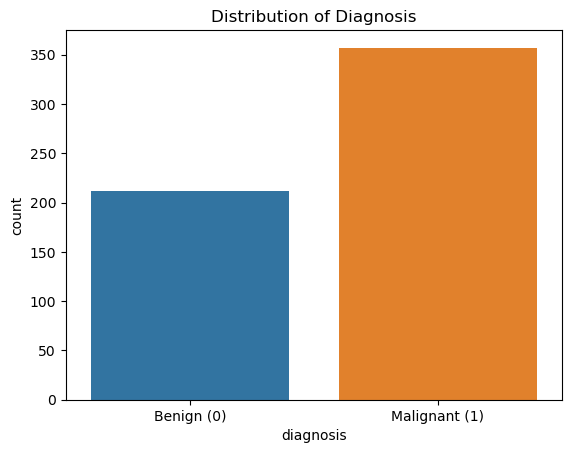

In [7]:
# Check the distribution of the target variable 'diagnosis' (1 = Malignant, 0 = Benign)
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Diagnosis')
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)']) 
plt.show()

The distribution of the target variable Diagnosis shows that there are 212 malignant (M) cases and 357 benign (B) cases. The dataset appears to be reasonably balanced, which is good for training a classifier. However, care should still be taken to check if the model performance is skewed due to any class imbalances. In cases of significant imbalance, techniques such as oversampling or undersampling may be needed.

### 2. Pairplot & Correlation for the Mean features 

I decided to focus on the mean values of the features for simplicity and clarity. These visualizations helped identify potential relationships and patterns in the data. However, it’s important to note that this analysis is not representative of the final model, as more granular features (like worst and se) were also explored but excluded from the final project. The goal here was to keep the analysis concise while still revealing key trends that might inform the modeling process.

In [8]:
selected_features = ['perimeter_mean', 'radius_mean', 'area_mean', 'concavity_mean', 'compactness_mean', 
                     'texture_mean', 'smoothness_mean', 'symmetry_mean', 'concave points_mean', 'fractal_dimension_mean']

# Add 'diagnosis' to the list for hue in pairplot
selected_features.append('diagnosis')

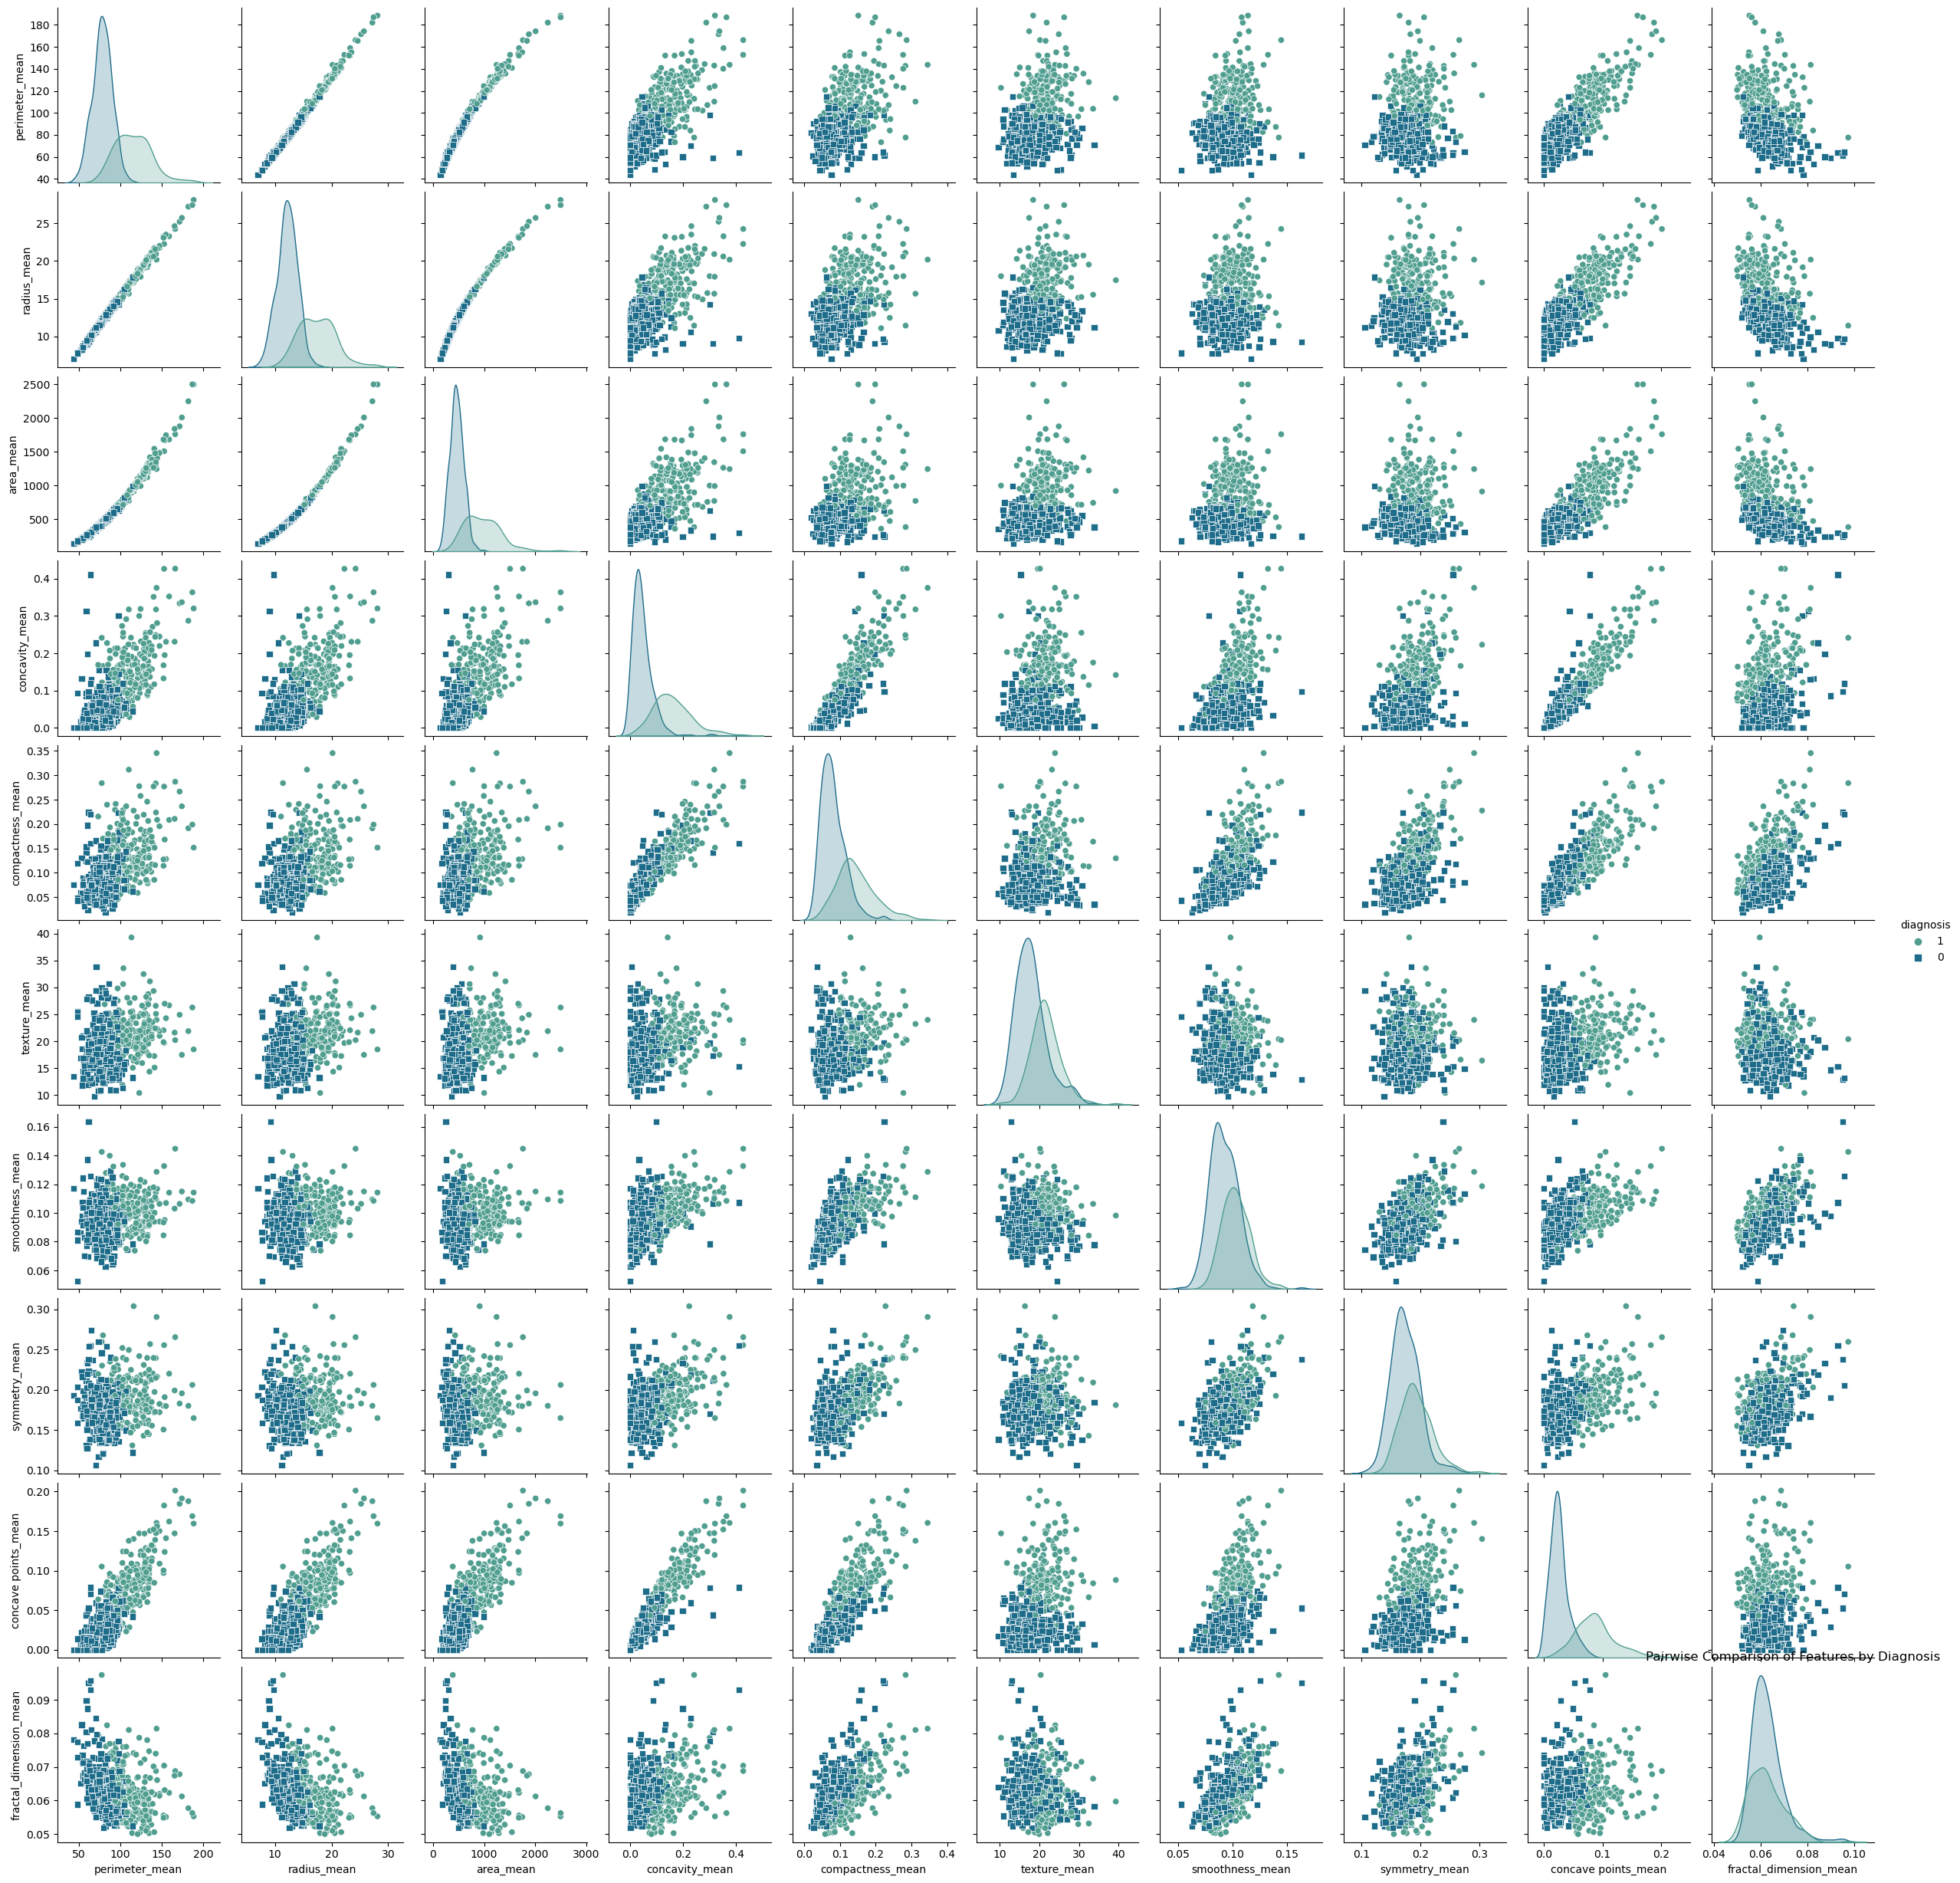

In [9]:
# Pairplot for the selected features
sns.pairplot(df[selected_features], hue='diagnosis', markers=["o", "s"], palette="crest")
plt.title('Pairwise Comparison of Features by Diagnosis')
plt.show()

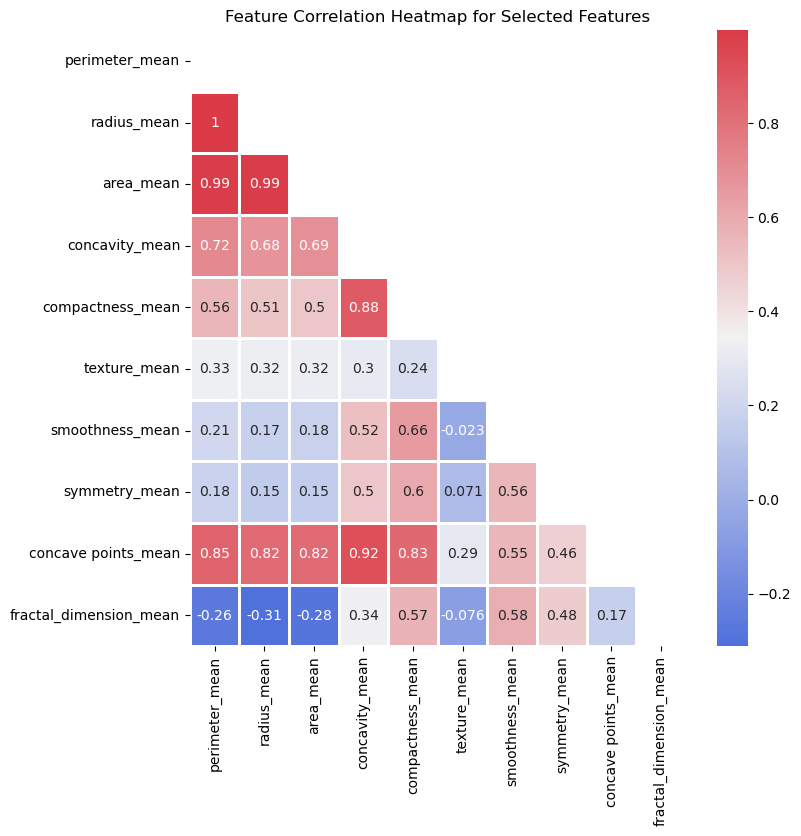

In [10]:
# Compute the correlation matrix for the selected features
corr = df[selected_features].corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))
plt.title('Feature Correlation Heatmap for Selected Features')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2g', linewidths=2)
plt.show()

The **mean values of cell radius, perimeter, area, compactness, concavity, and concave points** are useful indicators for cancer classification, as **higher values** of these features are generally associated with **malignant tumors**.

On the other hand, **mean values of texture, smoothness, symmetry, and fractal dimension** do not exhibit a strong distinction between benign and malignant cases.

Additionally, the **visualisations didn't reveal any significant outliers**, suggesting that no further data cleaning is necessary in this regard.

## Model Comparison of the Baseline Models

In [11]:
# Define features (X) and target (y)
X = df.drop('diagnosis', axis = 1).values 
y = df['diagnosis'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Check the shapes of the resulting datasets
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Training features shape: (455, 30)
Test features shape: (114, 30)
Training labels shape: (455,)
Test labels shape: (114,)


In this section, we define a list of different classification models to evaluate their performance using cross-validation.

In [12]:
models_list = [
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=50)),
    ('SVM', SVC(kernel='linear')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=100))
]


We will use 10-fold cross-validation to evaluate each model's accuracy.

In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

num_folds = 10
results = []
names = []

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

for name, model in models_list:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    start = time.time()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print(f"Model: {name}")
    print(f"Mean Accuracy: {cv_results.mean():.4f}")
    print(f"Standard Deviation: {cv_results.std():.4f}")
    print(f"Run Time: {end - start:.2f} seconds")
    print("-" * 50) 

Model: KNN
Mean Accuracy: 0.9209
Standard Deviation: 0.0355
Run Time: 0.14 seconds
--------------------------------------------------
Model: AdaBoost
Mean Accuracy: 0.9495
Standard Deviation: 0.0199
Run Time: 1.08 seconds
--------------------------------------------------
Model: SVM
Mean Accuracy: 0.9494
Standard Deviation: 0.0263
Run Time: 7.95 seconds
--------------------------------------------------
Model: Decision Tree
Mean Accuracy: 0.9252
Standard Deviation: 0.0204
Run Time: 0.06 seconds
--------------------------------------------------
Model: Random Forest
Mean Accuracy: 0.9538
Standard Deviation: 0.0232
Run Time: 1.30 seconds
--------------------------------------------------


The best performing model is the Random Forest with a mean accuracy of 95.38%.

## Standardised Model Comparison

In this section, I applied standardisation to the data (using StandardScaler) to check if scaling affects the performance of the models. 

In [14]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='1'),
    'f1': make_scorer(f1_score, pos_label='1'),
    'roc_auc': 'roc_auc'  
}

# Initialize list for pipelines
pipelines = []

# Wrap models in pipeline with StandardScaler
for name, model in models_list:
    pipelines.append((f'Scaled{name}', Pipeline([('Scaler', StandardScaler()), (name, model)])))

# KFold setup
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)

# Evaluation
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for name, model in pipelines:
        start = time.time()

        scores = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        
        end = time.time()
        
        print(f"Model: {name}")
        print(f"Accuracy: {scores['test_accuracy'].mean():.4f}")
        print(f"Precision: {scores['test_precision'].mean():.4f}")
        print(f"F1 Score: {scores['test_f1'].mean():.4f}")
        print(f"ROC AUC: {scores['test_roc_auc'].mean():.4f}")
        print(f"Run Time: {end - start:.2f} seconds")
        print("-" * 50)


Model: ScaledKNN
Accuracy: 0.9648
Precision: 0.9950
F1 Score: 0.9509
ROC AUC: 0.9927
Run Time: 0.08 seconds
--------------------------------------------------
Model: ScaledAdaBoost
Accuracy: 0.9495
Precision: 0.9498
F1 Score: 0.9271
ROC AUC: 0.9829
Run Time: 1.27 seconds
--------------------------------------------------
Model: ScaledSVM
Accuracy: 0.9670
Precision: 0.9603
F1 Score: 0.9525
ROC AUC: 0.9942
Run Time: 0.07 seconds
--------------------------------------------------
Model: ScaledDecision Tree
Accuracy: 0.9164
Precision: 0.8884
F1 Score: 0.8827
ROC AUC: 0.9095
Run Time: 0.07 seconds
--------------------------------------------------
Model: ScaledRandom Forest
Accuracy: 0.9560
Precision: 0.9574
F1 Score: 0.9367
ROC AUC: 0.9884
Run Time: 1.56 seconds
--------------------------------------------------


The Scaled SVM model has the best performance with a mean accuracy of of 96.7%.

It also had a precision of 96.03%, F1 score of 95.25%, and the highest ROC AUC of 99.42%, reflecting excellent ability to distinguish between malignant and benign tumors.

Additionally, it had one of the fastest runtimes at just 0.07 seconds, making it both accurate and efficient.

## Hyperparameter Tuning for SVM

I performed hyperparameter tuning using GridSearchCV to find the best values for the regularization parameter C and kernel type for SVM model.

In [15]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, shuffle = True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.978068 using {'C': 1.0, 'kernel': 'rbf'}
0.971449 (0.024189) with: {'C': 0.1, 'kernel': 'linear'}
0.841787 (0.048861) with: {'C': 0.1, 'kernel': 'poly'}
0.940676 (0.022046) with: {'C': 0.1, 'kernel': 'rbf'}
0.944976 (0.028196) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.967101 (0.026382) with: {'C': 0.3, 'kernel': 'linear'}
0.885604 (0.038108) with: {'C': 0.3, 'kernel': 'poly'}
0.964783 (0.024412) with: {'C': 0.3, 'kernel': 'rbf'}
0.962609 (0.024080) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.969324 (0.022172) with: {'C': 0.5, 'kernel': 'linear'}
0.896618 (0.036965) with: {'C': 0.5, 'kernel': 'poly'}
0.967053 (0.020072) with: {'C': 0.5, 'kernel': 'rbf'}
0.960435 (0.021443) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.969324 (0.022172) with: {'C': 0.7, 'kernel': 'linear'}
0.898792 (0.035935) with: {'C': 0.7, 'kernel': 'poly'}
0.971449 (0.013939) with: {'C': 0.7, 'kernel': 'rbf'}
0.953816 (0.026855) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.969324 (0.022172) with: {'C': 0.9, 'kernel': 'linear'

## Final Model Training and Testing

Using the best hyperparameters from grid searc, I trained the final model and evaluated it on the test data.

In [16]:
# prepare the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = SVC(C=2.0, kernel='rbf')
start = time.time()
model.fit(X_train_scaled, y_train)
end = time.time()
print( "Run Time: %f" % (end-start))

Run Time: 0.003455


In [17]:
# estimate accuracy on test dataset
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)

In [18]:
print("Accuracy score %f" % accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy score 0.982456
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [19]:
print(confusion_matrix(y_test, predictions))

[[71  0]
 [ 2 41]]


# Conclusion

In this project, various machine learning models were evaluated for their ability to predict a diagnosis based on the given dataset. Initially, five models; K-Nearest Neighbors (KNN), AdaBoost, Support Vector Machine (SVM), Decision Tree, and Random Forest were tested using cross-validation. Among these, Random Forest emerged as the best-performing model with a mean accuracy of 95.38%, demonstrating its robustness and efficiency in classification tasks.

To further enhance model performance, standardization and scaling techniques were applied. After scaling the data, the Support Vector Machine (SVM) model achieved the highest accuracy of 96.7%, with a low standard deviation, indicating a more stable and reliable performance across different subsets of the data.

Finally, hyperparameter tuning was performed using a GridSearchCV, leading to the identification of the optimal parameters for the SVM model. The tuned SVM model with C=1.0 and the RBF kernel achieved an accuracy of 98.25% on the test dataset, further demonstrating the effectiveness of model optimization.

In conclusion, after applying feature scaling and hyperparameter optimization, the SVM (RBF) model performed best, achieving a high accuracy of 98.25%. This indicates that, with careful preprocessing and model selection, machine learning models can be highly effective for predictive tasks such as diagnosing medical conditions.